# Prediction of Test Stock Prices

## Data preparation

In [7]:

import torch
import numpy as np
import pandas as pd


In [8]:
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class CustomDataset(Dataset):
    
    def __init__(self, df_file, ratio_train, ds_type, past_days):
        self.df_file = df_file
        self.df = pd.read_csv(self.df_file)
        
        self.df.drop(['Date'], axis=1, inplace=True)
        self.means = self.df.mean(axis=0)
        self.stds = self.df.std(axis=0)
        self.df = (self.df-self.means) / self.stds
        
        self.past_days=past_days
        self.ratio_train = ratio_train
        self.ds_type = ds_type
        self.num_train = int(self.ratio_train * len(self.df))
        self.num_test = len(self.df) - self.num_train
        if self.ds_type == 'train':
            self.df = self.df.iloc[:self.num_train]
        elif self.ds_type == 'test':
            self.df = self.df.iloc[self.num_train:]

    def __len__(self):
        if self.ds_type == 'train':
            return self.num_train
        
        elif self.ds_type == 'test':
            return self.num_test

    def __getitem__(self, idx):
        if idx-self.past_days < 0 :
            idx = idx - (idx-self.past_days)
        x = torch.tensor(self.df.iloc[idx-self.past_days:idx][['Open', 'High', 'Low', 'Volume']].values, dtype=torch.float32).to(device)
        x = x.reshape(-1)
        y = torch.tensor(self.df.iloc[idx]['Close'], dtype=torch.float32).to(device)
        
        return x, y

In [9]:
df_file = 'data/TSLA.csv'
ds_train = CustomDataset(df_file, 0.8, 'train',5)
ds_test = CustomDataset(df_file, 0.8, 'test',5)

## Dataloading

In [10]:
from torch.utils.data import DataLoader

batch_size = 256
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

# Batch Sampling
for input,target in dl_train:
    print(input.shape, target.shape)

print()
# Batch Sampling
for input,target in dl_test:
    print(input.shape, target.shape)


torch.Size([256, 20]) torch.Size([256])
torch.Size([256, 20]) torch.Size([256])
torch.Size([256, 20]) torch.Size([256])
torch.Size([256, 20]) torch.Size([256])
torch.Size([256, 20]) torch.Size([256])
torch.Size([256, 20]) torch.Size([256])
torch.Size([256, 20]) torch.Size([256])
torch.Size([140, 20]) torch.Size([140])

torch.Size([256, 20]) torch.Size([256])
torch.Size([228, 20]) torch.Size([228])


In [11]:
# Linear Regression Model
from torch import nn
class linearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm1d(20)
        self.linear = nn.Linear(20, 100) 
    def forward(self, x):
        x = self.norm(x)
        out = self.linear(x)
        return out

model = linearRegression().to(device)


model = torch.nn.Sequential(
    # nn.BatchNorm1d(4),
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,1),
)
model = model.to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 250 #너무 오래걸려서 250만 했습니다
for epoch in range(num_epochs):    
    for input, target in dl_train:
        optimizer.zero_grad()
        pred = model(input)
        target = target.view(-1, 1)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        print(f'Epoch[{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')


#for name, param in model.named_parameters():
#    print (name, param.data.numpy(), end=' ')


Epoch[1/250], loss: 0.695989
Epoch[1/250], loss: 0.553506
Epoch[1/250], loss: 0.629096
Epoch[1/250], loss: 0.592979
Epoch[1/250], loss: 0.635187
Epoch[1/250], loss: 0.628794
Epoch[1/250], loss: 0.501761
Epoch[1/250], loss: 0.515712
Epoch[2/250], loss: 0.531164
Epoch[2/250], loss: 0.473100
Epoch[2/250], loss: 0.475674
Epoch[2/250], loss: 0.436031
Epoch[2/250], loss: 0.441389
Epoch[2/250], loss: 0.456686
Epoch[2/250], loss: 0.522703
Epoch[2/250], loss: 0.476496
Epoch[3/250], loss: 0.435112
Epoch[3/250], loss: 0.433162
Epoch[3/250], loss: 0.400041
Epoch[3/250], loss: 0.361369
Epoch[3/250], loss: 0.376607
Epoch[3/250], loss: 0.337420
Epoch[3/250], loss: 0.327533
Epoch[3/250], loss: 0.379937
Epoch[4/250], loss: 0.391526
Epoch[4/250], loss: 0.294189
Epoch[4/250], loss: 0.319544
Epoch[4/250], loss: 0.304321
Epoch[4/250], loss: 0.273850
Epoch[4/250], loss: 0.280567
Epoch[4/250], loss: 0.282988
Epoch[4/250], loss: 0.314692
Epoch[5/250], loss: 0.257604
Epoch[5/250], loss: 0.258542
Epoch[5/250], 

Prediction: 
 tensor([[ 1.3894],
        [ 0.9559],
        [ 1.3131],
        [ 1.0740],
        [ 0.1452],
        [ 0.8461],
        [ 0.9785],
        [ 0.8572],
        [ 0.4113],
        [ 0.6465],
        [ 1.2267],
        [ 0.3302],
        [ 0.5634],
        [ 0.4636],
        [ 0.8860],
        [ 0.2806],
        [ 1.3534],
        [ 0.5998],
        [ 0.8630],
        [ 0.5486],
        [ 0.7204],
        [ 0.4644],
        [ 1.0450],
        [ 0.5093],
        [ 1.3602],
        [ 0.4676],
        [ 0.7450],
        [ 2.8314],
        [ 0.8378],
        [ 0.4656],
        [ 1.2162],
        [ 0.2468],
        [ 1.3805],
        [ 1.0625],
        [ 0.6150],
        [ 1.0315],
        [ 0.7184],
        [ 0.7906],
        [ 1.0911],
        [ 1.1776],
        [ 3.1253],
        [ 0.5974],
        [ 0.5702],
        [ 0.9791],
        [ 1.2929],
        [ 1.6283],
        [ 0.3856],
        [ 0.4813],
        [ 0.8154],
        [ 0.2139],
        [ 0.6030],
        [ 0.8717]

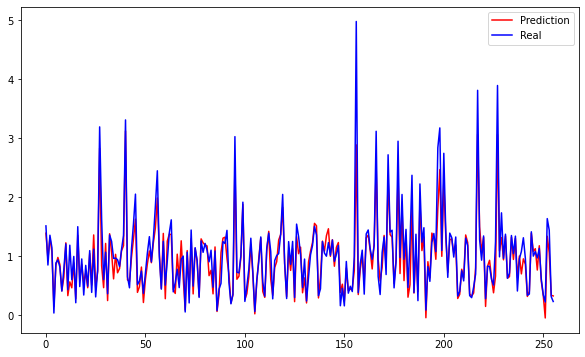

In [14]:
import matplotlib.pyplot as plt


model.eval()
input, target = next(iter(dl_test))
pred = model(input)
print("Prediction: \n",pred.data)
print("Real:", target.data)

plt.figure(figsize = (10,6))
plt.plot(pred.data.cpu(),'r-', label='Prediction')
plt.plot(target.data.cpu(),'b-', label='Real')
plt.legend()
plt.show()